# Customer Lifetime Value Predictions

In this notebook a machine learning model will be built to predict Customer Lifetime Value (CLV) of an online retail store.

Data can be found here:
*https://www.kaggle.com/datasets/vijayuv/onlineretail*


Step-by-step process:

- Define an appropriate time frame for Customer Lifetime Value calculation
- Identify the features we are going to use to predict future value and create them
- Calculate lifetime value (LTV) for training the machine learning model
- Build and run the machine learning model
- Check if the model is useful

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import plotly.express as px

from datetime import datetime, timedelta, date

## Data Import

In [2]:
data = pd.read_csv("../data/OnlineRetail.csv",encoding= 'unicode_escape')

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
data.shape

(541909, 8)

In [5]:
data.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

## Data Cleaning

Cleaning data

### Missing Values

In [6]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
data.loc[data.CustomerID.isnull() == True].tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,12/9/2011 10:26,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,12/9/2011 10:26,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,12/9/2011 10:26,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,12/9/2011 10:26,10.79,NaN,United Kingdom
541540,581498,DOT,DOTCOM POSTAGE,1,12/9/2011 10:26,1714.17,NaN,United Kingdom


In [8]:
data.dropna(axis=0, inplace= True)

In [9]:
data.shape

(406829, 8)

### Duplicates

In [10]:
## assessing the nr. of duplicates in the dataset
data.duplicated().sum()

5225

In [11]:
data.loc[data.duplicated() == True].tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,12/9/2011 11:34,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,12/9/2011 11:34,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,12/9/2011 11:34,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,12/9/2011 11:34,2.10,14446.0,United Kingdom
541701,581538,23343,JUMBO BAG VINTAGE CHRISTMAS,1,12/9/2011 11:34,2.08,14446.0,United Kingdom


The rows which are denoted as duplicates are sufficiently dissimilar to be valid data entries, and are therefore kept in the data.

### Outliers

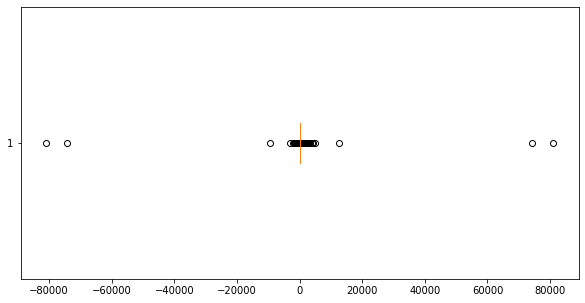

In [12]:
## Inspecting Outliers in Quantity
plt.figure(figsize= (10,5))
plt.boxplot(data.Quantity, vert= False);

In [13]:
## inspecting the orders with the highest quantity
data.sort_values(by="Quantity", ascending=False).head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/2011 9:15,2.08,16446.0,United Kingdom
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346.0,United Kingdom


As there is no Information regarding whether the orders are valid or not, they will be dropped, in order not to skew the rest of the data.

In [14]:
## dropping rows where Quantity is negative, as well as outliers in quantity
idx = data.loc[data.Quantity < 0].index

data.drop(idx, inplace= True)

idx = data.sort_values(by="Quantity", ascending=False).head(2).index

data.drop(idx, inplace= True)

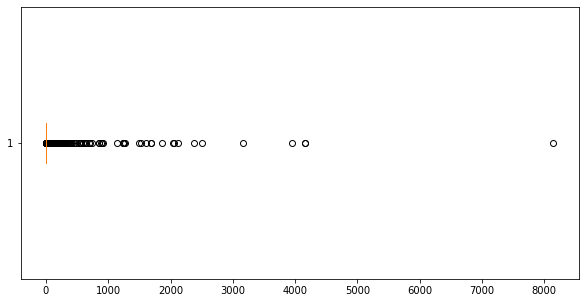

In [15]:
## Inspecting outliers in UnitPrice
plt.figure(figsize= (10,5))
plt.boxplot(data.UnitPrice, vert= False);

In [16]:
data.loc[data.UnitPrice == data.UnitPrice.max()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
173382,551697,POST,POSTAGE,1,5/3/2011 13:46,8142.75,16029.0,United Kingdom


As there is no information regarding validity of the unit prices, and they appear reasonable, they will be left in the data.

In [17]:
## changing InvoiceDate data type to datetime
data["InvoiceDate"] = pd.to_datetime(data.InvoiceDate)

In [18]:
data.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

## Data Exploration

Exploring statistical trends and distributions

In [19]:
data.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [20]:
## showing a statistical summary of the distribution of Quantity
data.Quantity.describe()

count    397922.000000
mean         12.631837
std          47.263643
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       12540.000000
Name: Quantity, dtype: float64

In [21]:
## inspecting the amount of individual customers
print(f"\nThere are, in total, {len(data.CustomerID.unique())} customers.\n")


There are, in total, 4338 customers.



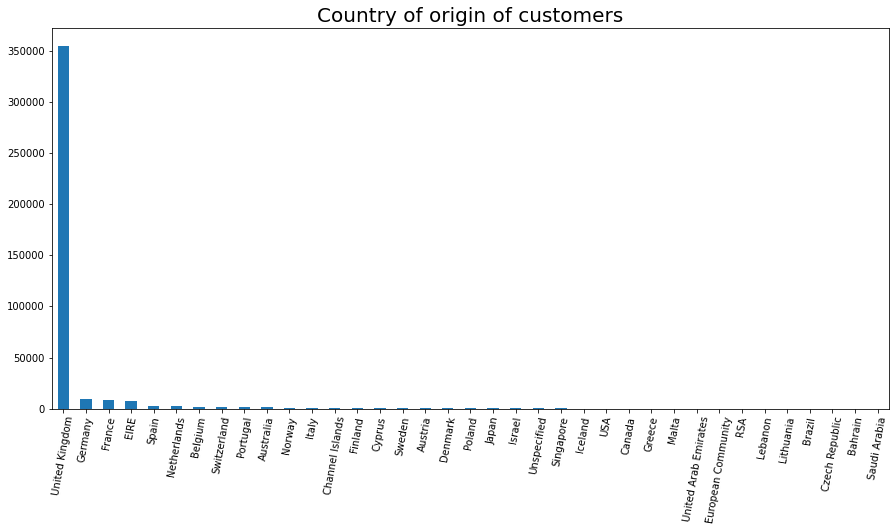

In [22]:
## inspecting country of origin of the customers
plt.figure(figsize=(15,7))
data.Country.value_counts().plot(kind="bar")
plt.title("Country of origin of customers", size=20)
plt.xticks(rotation=80);

In [23]:
## inspecting the timeframe of the dataset
earliest_date = data.InvoiceDate.min().date()
latest_date = data.InvoiceDate.max().date()

print(f"\nOrders in the dataset range from {earliest_date} to {latest_date}\n")


Orders in the dataset range from 2010-12-01 to 2011-12-09



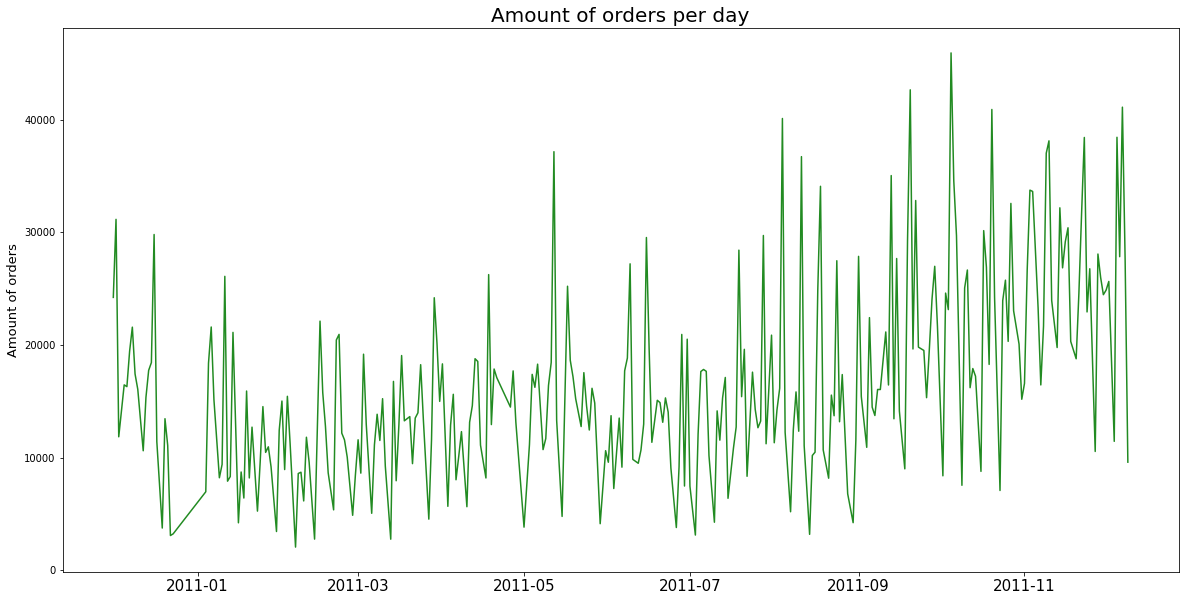

In [24]:
## inspecting amount of orders per day
date_df = data.copy()

date_df["date"] = date_df["InvoiceDate"].apply(lambda x: x.date())

date_df = pd.DataFrame(date_df.groupby("date")["Quantity"].sum()).reset_index().sort_values(by="date")

## plotting the distribution
plt.figure(figsize=(20,10))
plt.plot(date_df.date, date_df.Quantity, c= "forestgreen")
plt.title("Amount of orders per day", size=20)
plt.xticks(size=15)
plt.ylabel("Amount of orders", size=13);

### Calculating Revenue

In [25]:
## calculating revenue as sum of quantity and unit price per order
data["Revenue"] = data["Quantity"] * data["UnitPrice"]

## Customer Segmentation

This section segments customers into clusters based on Recency, Frequency and Monetary Value.

These features will then be used to forecast CLV.

In the first step, only the 3 months of data will be analysed and processed, which will then be used to predict the next 6 months.

# --New Approach to Segmentation--

In [93]:
data = data.loc[data['InvoiceDate'] < '2011-12-01']

In [96]:
def groupby_mean(x):
    return x.mean()

def groupby_count(x):
    return x.count()

def purchase_duration(x):
    return (x.max() - x.min()).days

def avg_frequency(x):
    return (x.max() - x.min()).days / x.count()

groupby_mean.__name__ = 'avg'
groupby_count.__name__ = 'count'
purchase_duration.__name__ = 'purchase_duration'
avg_frequency.__name__ = 'purchase_frequency'

In [91]:
def group_by_3M(df, clv_freq):
    '''This function slices the dataframe into chunks of a select timeframe.
    This is done so that previous timeframes can be used to predict CLV for a later timeframe.
    Ex.: Slicing into 3 months timeframes, to predict the last chunk based on all previous ones.'''
    
    df_orders = df.groupby(['CustomerID', 'InvoiceNo']).agg({'Revenue': sum, 'InvoiceDate': max})

    df_data = df_orders.reset_index().groupby([
                'CustomerID',
                pd.Grouper(key='InvoiceDate', freq=clv_freq)
                ]).agg({'Revenue': [sum, groupby_mean, groupby_count],})

    df_data.columns = ['_'.join(col).lower() for col in df_data.columns]
    
    df_data.reset_index(inplace= True)
    
    map_date_month = {str(x)[:10]: 'M_%s' % (i+1) for i, x in enumerate(
                    sorted(df_data.reset_index()['InvoiceDate'].unique(), reverse=True))}
    
    df_data["M"] = df_data["InvoiceDate"].apply(lambda x: map_date_month[str(x)[:10]])
    
    return df_data
    
    

In [109]:
df_data = group_by_3M(data, clv_freq='3M')

df_data.head()

,CustomerID,InvoiceDate,revenue_sum,revenue_avg,revenue_count,M
0,12347.0,2010-12-31,711.79,711.790,1,M_5
1,12347.0,2011-03-31,475.39,475.390,1,M_4
2,12347.0,2011-06-30,1018.77,509.385,2,M_3
3,12347.0,2011-09-30,584.91,584.910,1,M_2
4,12347.0,2011-12-31,1294.32,1294.320,1,M_1


In [ ]:
df_features = pd.pivot_table(
                df_data.loc[df_data['M'] != 'M_1'], 
                values=['sales_sum', 'sales_avg', 'sales_count'], 
                columns='M', 
                index='CustomerID')

In [ ]:
## making 3 - months and 6 - months dataframes
data_3m = data[(data.InvoiceDate.dt.date < date(2011,6,1)) & (data.InvoiceDate.dt.date >= date(2011,3,1))].reset_index()
data_6m = data[(data.InvoiceDate.dt.date >= date(2011,6,1)) & (data.InvoiceDate.dt.date < date(2011,12,1))].reset_index()

In [ ]:
data_3m.shape

### Calculating *Recency*

Finding out most recent purchase date for each customer, and see how many days they have been inactive for.

Afterwards, k-Means clustering will be applied to assign a *recency score*.

In [ ]:
## creating a new dataframe using customer ID
user_df = pd.DataFrame(data_3m.CustomerID.unique(), columns= ["CustomerID"])

In [ ]:
## get the latest purchase date for each customer and assign it to a new column
latest_purchase_df = pd.DataFrame(data_3m.groupby("CustomerID").InvoiceDate.max().reset_index())
latest_purchase_df.columns = ["CustomerID", "LatestPurchaseDate"]

In [ ]:
## calculate difference between observation date (overall latest invoice date) 
## and latest invoice date per customer
latest_purchase_df["Recency"] = (data_3m.InvoiceDate.max() - latest_purchase_df["LatestPurchaseDate"]).dt.days

In [ ]:
## merge the dataframe
recency_df = pd.merge(user_df, latest_purchase_df[["CustomerID", "Recency"]], on="CustomerID")

In [ ]:
## plotting recency
plt.figure(figsize=(15,7))
sns.histplot(data=recency_df.Recency, bins=50)
plt.title("Distribution of Recency Data", size=15);

In [ ]:
## statistical summary of recency data
recency_df.Recency.describe()

In [ ]:
## applying K-Means Clustering
from sklearn.cluster import KMeans

sse= {}
recency = recency_df[["Recency"]]
for k in range(1,10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(recency)
    recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_

In [ ]:
## plotting inertia to determine optimal nr. of clusters
plt.figure(figsize=(10,6))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.title("Inertia of KMeans Clustering for Recency", size=15);

According to the inertia graph, 3 appears to be the optimal number of clusters.

In [ ]:
## assigning clusters to all customers in the dataset
kmeans = KMeans(n_clusters= 3)
kmeans.fit(recency_df[["Recency"]])
recency_df["RecencyCluster"] = kmeans.predict(recency_df[["Recency"]])

In [ ]:
## function for ordering cluster numbers, to have an order based on "value"
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    
    new_cluster_field_name = 'new_' + cluster_field_name
    
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    
    df_new['index'] = df_new.index
    
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    
    df_final = df_final.drop([cluster_field_name],axis=1)
    
    df_final = df_final.rename(columns={"index":cluster_field_name})
    
    return df_final

In [ ]:
## applying order_cluster() to recency_df
recency_df = order_cluster('RecencyCluster', 'Recency',recency_df,False)

In [ ]:
## inspecting statistics for all clusters
recency_df.groupby("RecencyCluster")["Recency"].describe()

In [ ]:
recency_df.head()

In [ ]:
## including recency data in user_df
user_df= pd.merge(user_df, recency_df, on= "CustomerID")

### Calculating Frequency

Find the total number of orders for each customer

In [ ]:
## making dataframe with total number of orders per customer
frequency_df = data_3m.groupby("CustomerID").InvoiceDate.count().reset_index()
frequency_df.columns = ["CustomerID", "Frequency"]

frequency_df.head()

In [ ]:
## plotting the distribution
plt.figure(figsize=(15,7))
sns.histplot(frequency_df["Frequency"], bins=100)
plt.title("Distribution of buying frequency per customer", size=15);

In [ ]:
## applying frequency clusters

sse= {}
frequency = frequency_df[["Frequency"]]
for k in range(1,10):
    kmeans= KMeans(n_clusters= k, max_iter=1000).fit(frequency)
    frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_

In [ ]:
## plotting inertia
plt.figure(figsize=(10,6))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.title("Inertia of KMeans Clustering for Frequency", size=15);

It appears that the best number of clusters is 5.

In [ ]:
## fitting the clusters to the customers
kmeans = KMeans(n_clusters= 5, max_iter=1000).fit(frequency_df[["Frequency"]])
frequency_df["FrequencyCluster"] = kmeans.predict(frequency_df[["Frequency"]])

In [ ]:
frequency_df = order_cluster("FrequencyCluster", "Frequency", frequency_df, True)

In [ ]:
## inspecting statistics for all clusters
frequency_df.groupby("FrequencyCluster")["Frequency"].describe()

In [ ]:
## including frequency data in user_df
user_df= pd.merge(user_df, frequency_df, on= "CustomerID")

### Calculating Monetary Value

Clustering Customers based on Revenue.

In [ ]:
## assessing total revenue per customer
revenue_df = data_3m.groupby("CustomerID")["Revenue"].sum().reset_index()

In [ ]:
## plotting the revenue distribution
plt.figure(figsize=(15,7))
sns.histplot(revenue_df["Revenue"], bins=100)
plt.title("Distribution of buying frequency per customer", size=15);

In [ ]:
## clustering based on revenue
sse = {}
revenue = revenue_df[["Revenue"]]
for k in range(1,10):
    kmeans= KMeans(n_clusters= k, max_iter= 1000).fit(revenue)
    revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_

In [ ]:
## plotting inertia
plt.figure(figsize=(10,6))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.title("Inertia of KMeans Clustering for Revenue", size=15);

Based on the inertia plot, the optimal number of clusters is 5.

In [ ]:
## clustering customers based on revenue
kmeans = KMeans(n_clusters= 5, max_iter= 1000)
kmeans.fit(revenue_df[["Revenue"]])

revenue_df["RevenueCluster"] = kmeans.predict(revenue_df[["Revenue"]])

revenue_df = order_cluster("RevenueCluster", "Revenue", revenue_df, True)

In [ ]:
## inspecting descriptive statistics for all revenue clusters
revenue_df.groupby("RevenueCluster")["Revenue"].describe()

In [ ]:
## including revenue data in user_df
user_df= pd.merge(user_df, revenue_df, on= "CustomerID")

### Making final dataframe

In [ ]:
user_df.head()

In [ ]:
## applying over all scoring by adding cluster numbers
user_df["OverallScore"] = user_df["RecencyCluster"] + user_df["FrequencyCluster"] + user_df["RevenueCluster"]

In [ ]:
## creating the final dataframe
user_df.groupby("OverallScore")["Recency", "Frequency", "Revenue"].mean()

In [ ]:
## binning the clusters into classes
user_df["Segment"] = 'Low-Value'
user_df["Segment"].loc[user_df.OverallScore>3] = "Mid-Value"
user_df["Segment"].loc[user_df.OverallScore>6] = "High-Value"

In [ ]:
## inspecting the final dataframe
user_df.head()

## Plotting the customer segmentation

In [ ]:
## dropping outliers in frequency

for col in ["Frequency", "Recency", "Revenue"]:

    mask = user_df[col] > user_df[col].quantile(0.99)

    user_df.drop(user_df[mask].index, inplace=True)

## plotting with plotly
fig = px.scatter_3d(user_df, x='Frequency', y='Recency', z='Revenue', color= "OverallScore",
                   size_max=5, opacity= 0.6)

fig.show()

In [ ]:
user_df.shape

### Calculating 6-months lifetime value (LTV)

The 6-months LTV is going to be used for training the machine learning algorithm.

As this is going to be a supervised learning task, the RFM features that have just been created will be used to predict the 6-months LTV, which will be calculated next.

In [ ]:
## making the 6m user dataframe with the sum of revenue generated per customer
user_df_6m = data_6m.groupby("CustomerID")["Revenue"].sum().reset_index()
user_df_6m.columns = ["CustomerID", "6m_Revenue"]

In [ ]:
## visualizing the distribution of revenue per customer
plt.figure(figsize=(15,7))
sns.histplot(user_df_6m["6m_Revenue"], bins= 50)

In [ ]:
## merging 6-months and 3-months dataframes
df_merged = pd.merge(user_df, user_df_6m, on="CustomerID", how='left')
df_merged.shape

In [ ]:
## as there are nan-values in the dataset, they will be dropped
df_merged.dropna(inplace=True)
df_merged.shape

In [ ]:
## removing outliers from df_merged
df_merged = df_merged[df_merged['6m_Revenue'] < df_merged["6m_Revenue"].quantile(0.99)]

In [ ]:
df_merged["6m_Revenue"].describe()

In [ ]:
## plotting 6 months LTV distribution per RFM cluster
df_graph = df_merged.loc[df_merged["6m_Revenue"] < 30000]

plt.figure(figsize=(20,10))
sns.stripplot(data= df_graph,
                 x= df_graph["OverallScore"],
                 y= df_graph["6m_Revenue"],
                 size=10,
                 alpha= 0.7)

plt.title("6 Months Revenue per RFM - Customer Segment", size= 20)
plt.ylabel("6 Months LTV", size= 15)
plt.xlabel("RFM - Customer Segment", size= 15);

From the above graph it is visible that there seems to be a positive correlation between RFM scores and 6 months LTV.

### Clustering LTV

The business problem here is to predict which customers will have a high LTV, so that the business can act on that insight (e.g. with targeted marketing and retention campaigns).

Therefore, the target variable will be LTV - segments, which classify customers as having either high, medium, or low 6-months LTV.

In [ ]:
## clustering 6 months LTV
kmeans = KMeans(n_clusters= 3, max_iter= 1000)
kmeans.fit(df_merged[["6m_Revenue"]])

df_merged["LTVCluster"]= kmeans.predict(df_merged[["6m_Revenue"]])

df_merged = order_cluster("LTVCluster", "6m_Revenue", df_merged, True)

In [ ]:
df_merged.groupby("LTVCluster")["6m_Revenue"].describe()

## Feature Engineering

In [ ]:
from sklearn.preprocessing import OneHotEncoder, RobustScaler

In [ ]:
df_merged.head(3)

In [ ]:
## encoding the 'segment' column
final_df = pd.get_dummies(df_merged)
final_df.head()

In [ ]:
## scaling numerical features

for col in ["Recency", "Frequency", "Revenue"]:
    
    scaler = RobustScaler()
    
    scaler.fit(final_df[[col]])
    
    final_df[col] = scaler.transform(final_df[[col]])

In [ ]:
## dropping 6 months revenue column (cannot be used for prediction due to data leakage)
#final_df.drop("6m_Revenue", axis= 1, inplace= True)

In [ ]:
final_df.head()

In [ ]:
## inspecting correlations within the data to assess which features might be useful

plt.figure(figsize=(15,10))
sns.heatmap(final_df.drop("CustomerID", axis=1).corr(), annot=True)

## Modeling

Training the XGBoost algorithm to predict CLV.

### Classification

In [ ]:
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error
from sklearn.dummy import DummyClassifier, DummyRegressor

In [ ]:
final_df.head(3)

In [ ]:
X = final_df.drop(["CustomerID", "LTVCluster", "6m_Revenue"], axis=1)
y = final_df[["LTVCluster"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25)

using all features for now, then testing with feature importace

In [ ]:
## establishing prediction baseline
dummy = DummyClassifier()

dummy.fit(X_train, y_train)

acc = dummy.score(X_test, y_test)

print(f"The prediction accuracy baseline is {round(acc, 2)}")

In [ ]:
## instantiating and fitting XGBClassifier
clv_xgb_model_param = xgb.XGBClassifier(max_depth= 5,
                                 learning_rate= 0.1,
                                 objective= 'multi:softprob',
                                 n_jobs= -1)

clv_xgb_model = xgb.XGBClassifier()

clv_xgb_model_param.fit(X_train, y_train)

In [ ]:
## evaluating XGB performance
acc = clv_xgb_model_param.score(X_test, y_test)

print(f"\nModel accuracy: {round(acc, 2)}\n")

In [ ]:
## inspecting classification report from sklearn
y_pred = clv_xgb_model_param.predict(X_test)

print(classification_report(y_test, y_pred))

### Regression

In [ ]:
final_df.head()

In [ ]:
## splitting the dataset into training and test data
X = final_df.drop(["CustomerID", "LTVCluster", "6m_Revenue"], axis= 1)
y = final_df[["6m_Revenue"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25)

In [ ]:
## establishing regression baseline scores
dummy = DummyRegressor()

dummy.fit(X_train, y_train)

y_pred = dummy.predict(X_test)

r2 = dummy.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

results = {
    "metric": ["r2", "mse", "rmse", "mae"],
    "value": [r2, mse, rmse, mae]
}

pd.DataFrame(results).set_index("metric").round(2)

In [ ]:
## predicting 6-months LTV using XGBRegressor
xgb_regressor = xgb.XGBRegressor()

xgb_regressor.fit(X_train, y_train)

y_pred = xgb_regressor.predict(X_test)

r2 = xgb_regressor.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

results = {
    "metric": ["r2", "mse", "rmse", "mae"],
    "value": [r2, mse, rmse, mae]
}

pd.DataFrame(results).set_index("metric").round(2)

## Conclusion

Currently, the model is performing barely better than the baseline model (DummyClassifier) with regards to classification.

This is likely due to strong imbalance in the dataset when it comes to the target variable.

Possible solutionw would be: 

- to apply balancing, for example by creating synthetic data for LTVClusters 1 & 2.

- to do more hyperparameter tuning

- to test different classifiers

- to use deep learning (neural networks)

The regression model on the other hand seems to perform very well, with r2 value of 0.99, a root mean squared error of 118.35 and a mean absolute error of 29.61.

# Sandbox

In [ ]:
from sklearn.model_selection import train_test_split, cross_validate

In [ ]:
def modeling(df):
    '''This function fits an XGBRegressor algorithm to the data,
    and predicts the lifetime value per Customer.'''
    
    X = df.drop(["CustomerID", "6m_Revenue", "LTVCluster"], axis= 1)
    y= df["6m_Revenue"]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25)
    
    xgb_regressor = xgb.XGBRegressor()
    
    xgb_regressor.fit(X_train, y_train)
    
    cv_results = cross_validate(xgb_regressor,
                               X= X_train,
                               y= y_train,
                               cv= 5,
                               scoring= ["neg_mean_squared_error"])
    
    score = abs(cv_results["test_neg_mean_squared_error"].mean())
    
    print(f'RMSE of XGBRegressor: {math.sqrt(score)}')
    
    return df, (X_train, X_test, y_train, y_test), xgb_regressor

In [ ]:
df_pred, data_split, model = modeling(final_df)

X_train, X_test, y_train, y_test = data_split[0], data_split[1], data_split[2], data_split[3]

In [ ]:
predicted_ltv = X_test
predicted_ltv["Predicted_LTV"] = model.predict(predicted_ltv)

predicted_ltv["CustomerID"] = list(range(0, len(predicted_ltv)))
predicted_ltv["Actual_LTV"] = y_test

predicted_ltv= predicted_ltv[["CustomerID", "Actual_LTV", "Predicted_LTV"]]


In [ ]:
predicted_ltv

In [ ]:
sample = predicted_ltv.sample(n= 50)

In [ ]:
X= sample["CustomerID"]
Y1 = sample["Predicted_LTV"]
Y2 = sample["Actual_LTV"]

X_axis = np.arange(len(X))

plt.figure(figsize=(20,10))
plt.bar(X_axis - 0.2, Y1, 0.4, label = 'Predicted LTV')
plt.bar(X_axis + 0.2, Y2, 0.4, label = 'Real LTV')

plt.title("Actual vs. Predicted Lifetime Value for 100 Random Customers", size= 20)
plt.ylabel('LTV', size= 15)
plt.legend();

In [ ]:
comparison_df = sample[["Actual_LTV", "Predicted_LTV"]].copy()

comparison_df["error"] = comparison_df["Actual_LTV"] - comparison_df["Predicted_LTV"]

comparison_df.head()

In [ ]:
plt.figure(figsize=(20,10))
plt.bar(list(range(0,len(comparison_df))),comparison_df["error"])